In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
def construct_grid(edge_list, alphas_on_lines, betas_on_lines, plot_it=False):
    """Create a grid from edge list, with traffic details stored in the edgedata."""

    # construct graph
    gra = nx.MultiDiGraph()
    for ee, edge in enumerate(edge_list):
        n, m = edge[0], edge[1]
        gra.add_edge(
            n,
            m,
            alpha=alphas_on_lines[ee],
            beta=betas_on_lines[ee],
            idx=ee,
            orientation=(n, m),
        )

    if plot_it:
        arc_rad = 0.1
        nx.draw(gra, connectionstyle=f"arc3, rad = {arc_rad}", with_labels=True)

        plt.show()

    return gra


def node_edge_incidence_matrix(nx_graph: nx.Graph):
    """Construct the node edge incidence matrix from a given networkx.MultiDiGraph.

    Args:
        nx_graph (networkx.Graph): Graph encoding the traffic network

    Returns:
        Tuple[list, np.ndarray, np.ndarray]: List of edges, E_matrix,
    """

    nr_nodes = len(nx_graph.nodes)
    nr_edges = len(nx_graph.edges)

    E_matrix = np.zeros((nr_nodes, nr_edges))

    edge_list = [xx for xx in nx_graph.edges(data=True)]

    for uu_r, kk_r, val_dict in edge_list:
        edge_idx = val_dict["idx"]
        direction = val_dict["orientation"]

        E_matrix[int(direction[0]), edge_idx] = 1
        E_matrix[int(direction[1]), edge_idx] = -1

    return edge_list, E_matrix


def edge_cycle_incidence_matrix(gra, reduce_to_basis=False):
    """Construct the edge cycle incidence matrix from a given networkx.MultiDiGraph.
    C_{e, c} = 1, iff edge is in the orintated cycle c.

    Args:
        nx_graph (networkx.Graph): Graph encoding the traffic network

    Returns:
        C_matrix,
    """
    # create a list of all simple cycles
    simple_cycles = nx.recursive_simple_cycles(gra)
    # TODO: need to reduce the cycles to minimal cycle set

    C_matrix = np.zeros((len(gra.edges), len(simple_cycles)))

    for cc, cycle in enumerate(simple_cycles):
        NN_nodes_cycle = len(cycle)
        for nn, node in enumerate(cycle):
            ee = gra.get_edge_data(node, cycle[(nn + 1) % NN_nodes_cycle])[0]["idx"]
            C_matrix[ee, cc] = 1

    # rank (does not work to reduce!!!!)
    if reduce_to_basis:
        rank = np.linalg.matrix_rank(C_matrix)
        # print(rank)
        C_matrix = C_matrix[:, :rank]
        # print(C_matrix.shape)
        # print(np.linalg.matrix_rank(C_matrix))

    return C_matrix, simple_cycles

In [3]:
# store some examples
def get_example(number):
    if number == 1:
        edge_list = [(0, 1), (1, 0), (1, 2), (2, 1), (2, 0), (0, 2)]
        beta_list = [1, 1, 1, 1, 1, 1]
        alpha_list = [1, 1, 1, 1, 1, 1]
        # set flow demands per node
        flow_per_origin = {0: [3, -1, -2], 1: [-2, 4, -2]}
        initial_guess_per_origin = {0: [1, 0, 0, 0, 0, 2], 1: [0, 2, 2, 0, 0, 0]}
    elif number == 2:
        edge_list = [(0, 1), (1, 0), (1, 2), (2, 1), (2, 0)]
        beta_list = [1, 1, 1, 1, 1]
        alpha_list = [1, 1, 1, 1, 1]
        flow_per_origin = {0: [3, -1, -2], 1: [-2, 4, -2]}
        initial_guess_per_origin = {0: [3, 0, 2, 0, 0], 1: [0, 2, 2, 0, 0]}
    elif number == 3:
        edge_list = [
            (0, 1),
            (1, 0),
            (1, 2),
            (2, 1),
            (2, 0),
            (0, 2),
            (0, 3),
            (3, 0),
            (2, 3),
            (3, 2),
        ]
        beta_list = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        alpha_list = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

        flow_per_origin = {0: [3, -1, -2, 0], 1: [-2, 4, -1, -1], 3: [-1, 0, -1, 2]}
        initial_guess_per_origin = {
            0: [1, 0, 0, 0, 0, 2, 0, 0, 0, 0],
            1: [0, 2, 2, 0, 0, 0, 0, 0, 1, 0],
            3: [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        }

    return edge_list, beta_list, alpha_list, flow_per_origin, initial_guess_per_origin

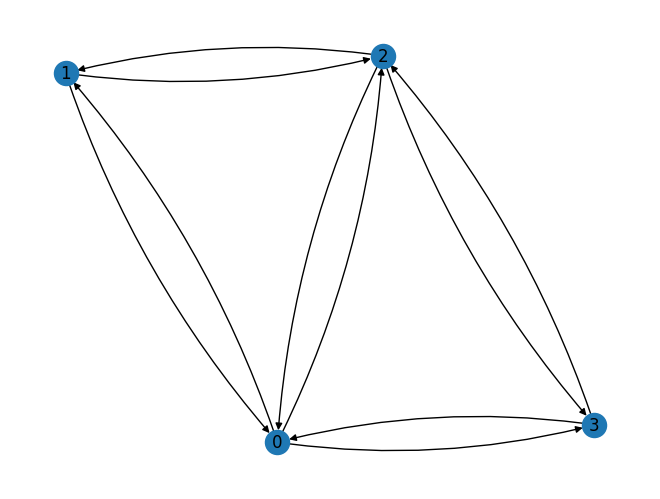

In [6]:
# construct minimal example graph
edge_list, beta_list, alpha_list, flow_per_origin, initial_guess_per_origin = (
    get_example(3)
)

gra = construct_grid(edge_list, alpha_list, beta_list, plot_it=True)

In [8]:
# get edge incidenc matrix
_, E_mtr = node_edge_incidence_matrix(gra)
C_mtr, simple_cylces = edge_cycle_incidence_matrix(gra)

# Sanity check, we must have EC=0, that is C\ell \in \ker E.
print(E_mtr @ C_mtr)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [9]:
### Saninty check that initial guess fulfills the KCL.
for node, nodal_in_out in flow_per_origin.items():
    print(nodal_in_out - E_mtr @ initial_guess_per_origin[node])

[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]


In [10]:
print(C_mtr)

[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]]


In [ ]:
def gradients_lagrangian(
    loop_flows_per_origin,
    mu_per_origin,
    initial_guess_per_origin,
    C_mtr,
    beta_list=[1, 1, 1, 1, 1, 1],
    alpha_list=[1, 1, 1, 1, 1, 1],
):
    NN_origins, NN_cycles, NN_edges = (
        len(initial_guess_per_origin.keys()),
        C_mtr.shape[1],
        C_mtr.shape[0],
    )

    # calc grad to loop flows
    grad_loop = np.zeros(NN)

In [ ]:
def gradients_lagrangian(
    loop_flows_per_origin,
    mu_per_origin,
    initial_guess_per_origin,
    C_mtr,
    beta_list=[1, 1, 1, 1, 1, 1],
    alpha_list=[1, 1, 1, 1, 1, 1],
):
    NN_origins, NN_cycles, NN_edges = (
        len(initial_guess_per_origin.keys()),
        C_mtr.shape[1],
        C_mtr.shape[0],
    )

    # calc grad to loop flows
    grad_loop = np.zeros(NN)